# Counting Boats from Space - Part 2

In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

## 1. Install Pytorch

In [2]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install plotly

## 2. Import requirements

In [3]:
# Various utilities
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage
import torch
from torch.utils.data import DataLoader

In [4]:
from src.dataset import getImageSetDirectories, S2_Dataset
from src.model import Model
from src.train import train, get_failures_or_success

In [5]:
torch.cuda.is_available() # gpu support

False

## 3. Init K-Fold Dataset

In [6]:
bands = ['img_08', 'bg_ndwi']
test_size = 0.2
data_dir = 'data/chips'

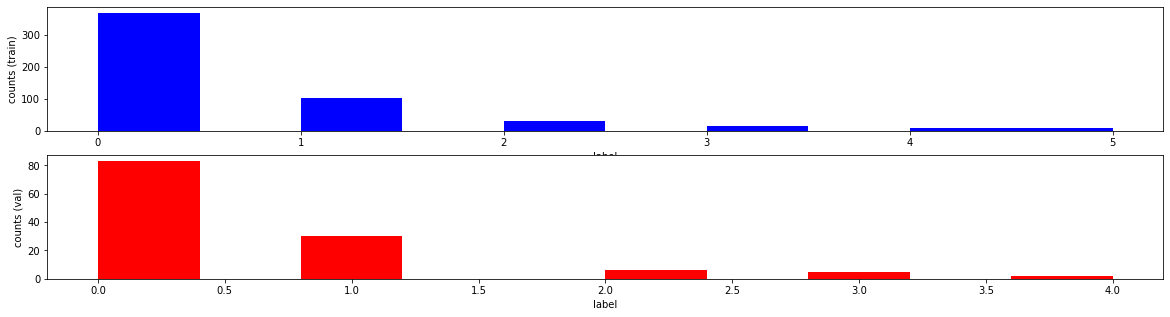

In [7]:
train_list, val_list, fig = getImageSetDirectories(data_dir=data_dir, band_list=bands, test_size=test_size, plot_coords=False, plot_class_imbalance=True, use_KFold=False)
fig # mapbox plot train/val coordinates

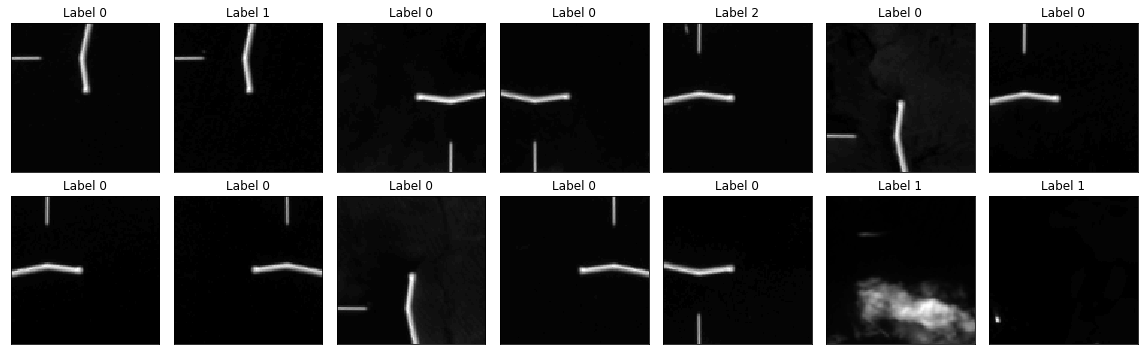

In [8]:
train_dataset = S2_Dataset(imset_dir=train_list[0], augment=True)
val_dataset = S2_Dataset(imset_dir=val_list[0], augment=False)
train_dataset.plot_dataset(n_frames=14, n_rows=2, cmap='gray')

## 4. Train PyTorch Classifier

In [9]:
##### TODO: Add / report metrics (precision, recall, F1, etc.) for boat presence + counts

In [10]:
# training config
input_dim = train_dataset[0]['img'].shape[0]
hidden_dim, kernel_size, pool_size, n_max = 16, 3, 10, 1

In [11]:
K_fold_metrics = []
for fold, (train_imset, val_imset) in enumerate(zip(train_list, val_list)):
    train_dataset = S2_Dataset(imset_dir=train_imset, augment=True)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=16)
    
    val_dataset = S2_Dataset(imset_dir=val_imset, augment=False)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

    best_metrics = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader,
                 input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max,
                 ld=0.2, water_ndwi=0.5,
                 n_epochs=1, lr=0.005, lr_step=2, lr_decay=0.95,
                 device='cpu', checkpoints_dir='./checkpoints', seed=fold, verbose=1, fold=fold)
    
    K_fold_metrics.append(best_metrics)

Number of trainable params 5286


Epoch 1: train_clf_error 1.31189 / train_reg_error 4.02867 / val_clf_error 1.07275 / val_reg_error 2.10637



In [12]:
print('MAX:  train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.max([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.max([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.max([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.max([metrics['val_reg_error'] for metrics in K_fold_metrics])))

print('MEAN: train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.mean([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.mean([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.mean([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.mean([metrics['val_reg_error'] for metrics in K_fold_metrics])))

print('MEAN:  train_accuracy {:.4f} / train_precision {:.4f} / train_recall {:.4f} / train_f1 {:.4f} '.format(
    np.mean([metrics['train_accuracy'] for metrics in K_fold_metrics]), np.mean([metrics['train_precision'] for metrics in K_fold_metrics]),
    np.mean([metrics['train_recall'] for metrics in K_fold_metrics]), np.mean([metrics['train_f1'] for metrics in K_fold_metrics])))

print('MEAN:  val_accuracy {:.4f} / val_precision {:.4f} / val_recall {:.4f} / val_f1 {:.4f} '.format(
    np.mean([metrics['val_accuracy'] for metrics in K_fold_metrics]), np.mean([metrics['val_precision'] for metrics in K_fold_metrics]),
    np.mean([metrics['val_recall'] for metrics in K_fold_metrics]), np.mean([metrics['val_f1'] for metrics in K_fold_metrics])))

print('MIN:  train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.min([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.min([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.min([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.min([metrics['val_reg_error'] for metrics in K_fold_metrics])))

MAX:  train_clf_error 1.3119 / train_reg_error 4.0287 / val_clf_error 1.0728 / val_reg_error 2.1064 
MEAN: train_clf_error 1.3119 / train_reg_error 4.0287 / val_clf_error 1.0728 / val_reg_error 2.1064 
MEAN:  train_accuracy 0.6894 / train_precision 0.0188 / train_recall 0.0493 / train_f1 0.0216 
MEAN:  val_accuracy 0.6587 / val_precision 0.0018 / val_recall 0.6588 / val_f1 0.0020 
MIN:  train_clf_error 1.3119 / train_reg_error 4.0287 / val_clf_error 1.0728 / val_reg_error 2.1064 


In [13]:
# MAX Epoch 100:  train_clf_error 0.5447 / train_reg_error 0.2832 / val_clf_error 0.6210 / val_reg_error 0.3806 
# MEAN Epoch 100: train_clf_error 0.1502 / train_reg_error 0.1566 / val_clf_error 0.2486 / val_reg_error 0.2087 
# MIN Epoch 100:  train_clf_error 0.0742 / train_reg_error 0.1155 / val_clf_error 0.0306 / val_reg_error 0.0319 

In [14]:
# Epoch 67: train_clf_error 0.12035 / train_reg_error 0.13437 / val_clf_error 0.03524 / val_reg_error 0.07710

In [15]:
### BANDS: B08 + bg_NDWI
# h=16, n=2, batch_size=8, lr_init=0.005, lr_decay=0.95 @ Epoch 87: Train Error 0.11129 / Val Error 0.06242

## 5. Test Model

In [16]:
top_1_clf = np.argmin([metrics['val_clf_error'] for metrics in K_fold_metrics])
print('Top 1 Clf (id {}): {:.4f} clf / {:.4f} count'.format(top_1_clf, K_fold_metrics[top_1_clf]['val_clf_error'], K_fold_metrics[top_1_clf]['val_reg_error']))

Top 1 Clf (id 0): 1.0728 clf / 2.1064 count


In [17]:
top_1_reg = np.argmin([metrics['val_reg_error'] for metrics in K_fold_metrics])
print('Top 1 Reg (id {}): {:.4f} clf / {:.4f} count'.format(top_1_reg, K_fold_metrics[top_1_reg]['val_clf_error'], K_fold_metrics[top_1_reg]['val_reg_error']))

Top 1 Reg (id 0): 1.0728 clf / 2.1064 count


In [18]:
# load pretrained model
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, device='cpu', fold=top_1_clf)
checkpoint_file = os.path.join('checkpoints', model.folder, 'model.pth')
model.load_checkpoint(checkpoint_file=checkpoint_file)
model = model.eval()

In [19]:
##### Display failures (train, val) and inspect hidden channels --> Re label?
get_failures_or_success(model, train_dataset, hidden_channel=1, success=False, filter_on=6)  # 13, 11, 10, 3